<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_Forecast_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required libraries*

In [1]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

# Importing the required packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [3]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


# Dates for which data will be extracted

In [4]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [5]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Get USD to EUR  price data from YFinance

In [6]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']]


1. seasonal : This component is very close to 0 indicating the lack of strong seasonal pattern
2. Trend : This is majority of the component and data fluctuates and shows pattern
3. resid : this is almost 0 ,which says after accounting for trend and seasonality , the reamning variation are very small

In [7]:
# # Extract day, month, and year as separate columns
# df_USD_EUR['Day'] = df_USD_EUR.index.day
# df_USD_EUR['Month'] = df_USD_EUR.index.month
# df_USD_EUR['Year'] = df_USD_EUR.index.year

# # Extract the day of the week as a separate column
# df_USD_EUR['DayOfWeek'] = df_USD_EUR.index.dayofweek  # Monday is 0 and Sunday is 6

# df_USD_EUR

#Visualizing the Pattern

In [8]:
# Define the start and end dates for train and test data
train_end_date = pd.to_datetime('2023-01-01')


In [9]:
df_USD_EUR['Original_USD_EUR_Price_MA_5'] = df_USD_EUR['Original_USD_EUR_Price'].rolling(window=5,min_periods=1).mean()


#df_USD_EUR.dropna(inplace=True)
df_USD_EUR.head(10)


,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5
Date,,
2019-01-01,1.149306,1.149306
2019-01-02,1.146171,1.147739
2019-01-03,1.131811,1.142429
2019-01-04,1.139108,1.141599
2019-01-07,1.141044,1.141488
2019-01-08,1.147974,1.141222
2019-01-09,1.145607,1.141109
2019-01-10,1.155495,1.145846
2019-01-11,1.151013,1.148227


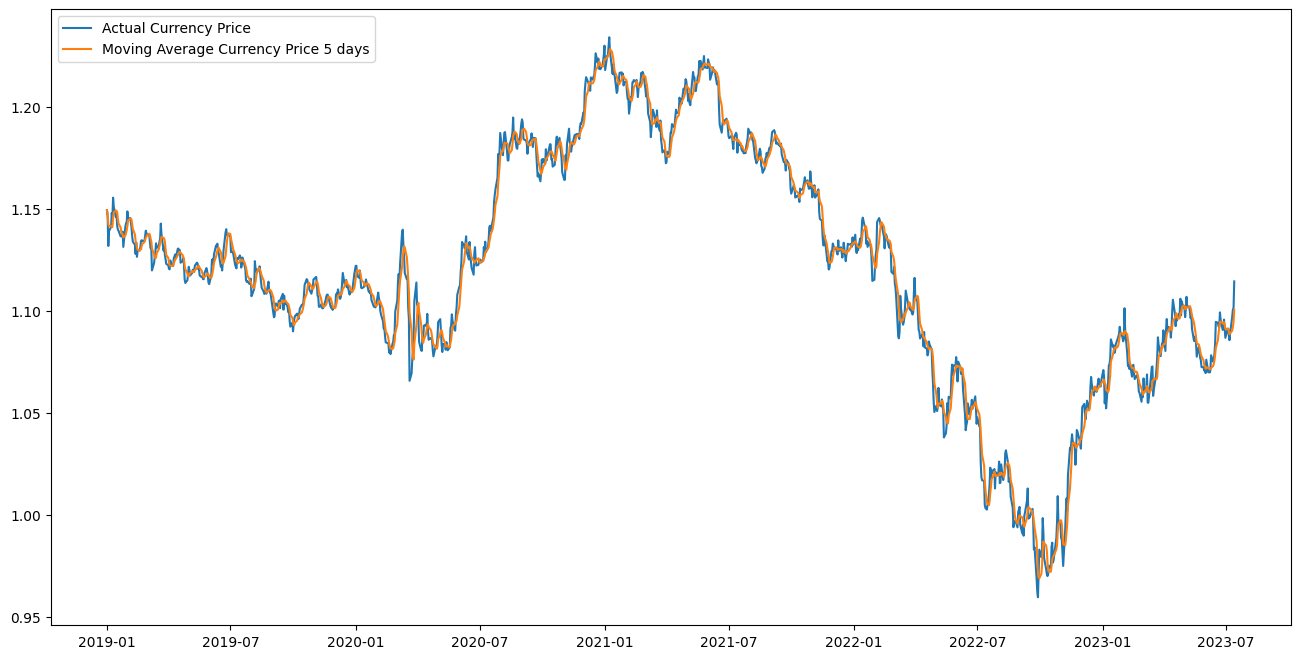

In [10]:
plt.figure(figsize=(16,8))
plt.plot(df_USD_EUR['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(df_USD_EUR['Original_USD_EUR_Price_MA_5'],label="Moving Average Currency Price 5 days")

plt.legend(loc="upper left")

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_USD_EUR[['Original_USD_EUR_Price_MA_5_Scaled']] = scaler.fit_transform(df_USD_EUR[['Original_USD_EUR_Price_MA_5']])
df_USD_EUR_5_days=df_USD_EUR.copy()

In [12]:
def generate_shift_columns(df, column_name, min_shift, max_shift):
    for i in range(min_shift, max_shift + 1):
        df[f'{column_name}_shift{i}'] = df[column_name].shift(i)
    return df


In [13]:
generate_shift_columns(df_USD_EUR, 'Original_USD_EUR_Price_MA_5_Scaled', 1, 4)
df_USD_EUR.head(10)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,Original_USD_EUR_Price_MA_5_Scaled_shift3,Original_USD_EUR_Price_MA_5_Scaled_shift4
Date,,,,,,,
2019-01-01,1.149306,1.149306,0.512162,NaN,NaN,NaN,NaN
2019-01-02,1.146171,1.147739,0.484971,0.512162,NaN,NaN,NaN
2019-01-03,1.131811,1.142429,0.392876,0.484971,0.512162,NaN,NaN
2019-01-04,1.139108,1.141599,0.378472,0.392876,0.484971,0.512162,NaN
2019-01-07,1.141044,1.141488,0.376548,0.378472,0.392876,0.484971,0.512162
2019-01-08,1.147974,1.141222,0.371925,0.376548,0.378472,0.392876,0.484971
2019-01-09,1.145607,1.141109,0.369966,0.371925,0.376548,0.378472,0.392876
2019-01-10,1.155495,1.145846,0.452131,0.369966,0.371925,0.376548,0.378472
2019-01-11,1.151013,1.148227,0.493431,0.452131,0.369966,0.371925,0.376548


In [14]:
df_USD_EUR.dropna(inplace=True)
df_USD_EUR.head(10)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,Original_USD_EUR_Price_MA_5_Scaled_shift3,Original_USD_EUR_Price_MA_5_Scaled_shift4
Date,,,,,,,
2019-01-07,1.141044,1.141488,0.376548,0.378472,0.392876,0.484971,0.512162
2019-01-08,1.147974,1.141222,0.371925,0.376548,0.378472,0.392876,0.484971
2019-01-09,1.145607,1.141109,0.369966,0.371925,0.376548,0.378472,0.392876
2019-01-10,1.155495,1.145846,0.452131,0.369966,0.371925,0.376548,0.378472
2019-01-11,1.151013,1.148227,0.493431,0.452131,0.369966,0.371925,0.376548
2019-01-14,1.146014,1.149220,0.510670,0.493431,0.452131,0.369966,0.371925
2019-01-15,1.147289,1.149083,0.508294,0.510670,0.493431,0.452131,0.369966
2019-01-16,1.141683,1.148299,0.494682,0.508294,0.510670,0.493431,0.452131
2019-01-17,1.139809,1.145161,0.440264,0.494682,0.508294,0.510670,0.493431


In [15]:
train_data_currency = df_USD_EUR[df_USD_EUR.index <= train_end_date]
test_data_currency = df_USD_EUR[df_USD_EUR.index > train_end_date]
train_data_currency.head(5)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,Original_USD_EUR_Price_MA_5_Scaled_shift3,Original_USD_EUR_Price_MA_5_Scaled_shift4
Date,,,,,,,
2019-01-07,1.141044,1.141488,0.376548,0.378472,0.392876,0.484971,0.512162
2019-01-08,1.147974,1.141222,0.371925,0.376548,0.378472,0.392876,0.484971
2019-01-09,1.145607,1.141109,0.369966,0.371925,0.376548,0.378472,0.392876
2019-01-10,1.155495,1.145846,0.452131,0.369966,0.371925,0.376548,0.378472
2019-01-11,1.151013,1.148227,0.493431,0.452131,0.369966,0.371925,0.376548


In [16]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



In [17]:
perform_adfuller(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -5.766066965055952
P-value: 5.52913484312877e-07
The time series is stationary.


In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


# Verifying the lags which can be selected for Training the model
##The lag value where the chart crosses the confidence interval for the first time can be good starting to point to select values of P(ACF) and Q(PACF)

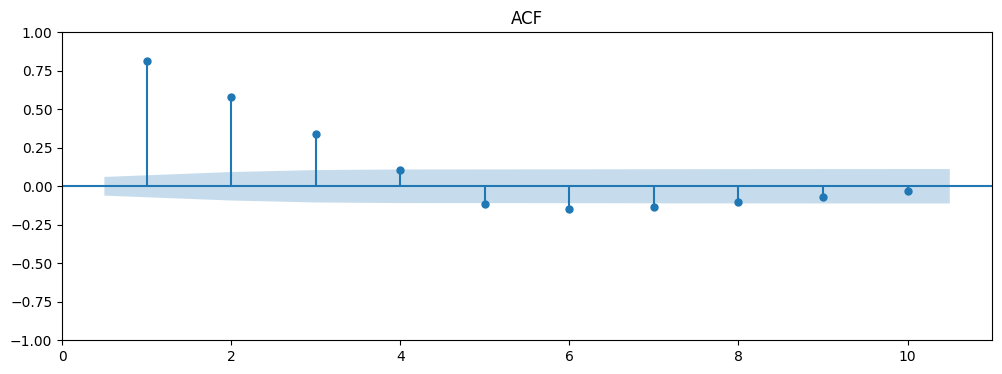

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


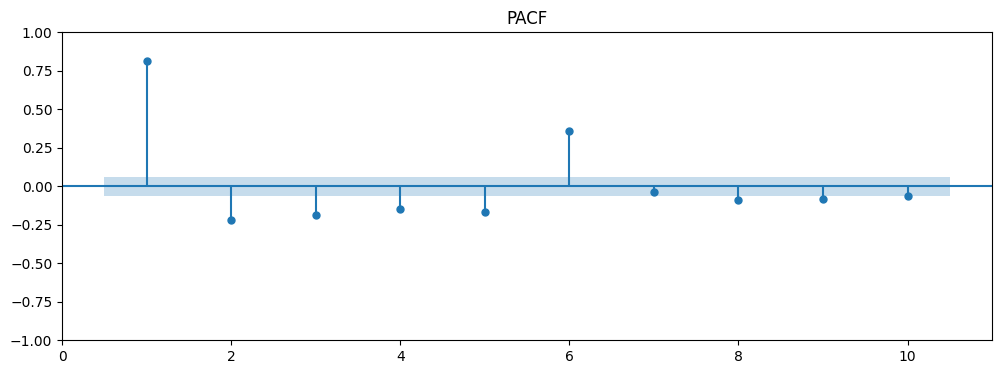

In [19]:
plot_acf_values(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'].diff(1),10)
plot_pacf_values(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'].diff(1),10)

# Auto Arima to find values of p,d,q

In [20]:
# from pmdarima import auto_arima

# model = auto_arima(train_data_currency['Original_USD_EUR_Price'],d=2,
#                    exog=train_data_currency[exogdata],
#                    seasonal=False,   # No Seasonality
#                    trace=True,
#                    error_action='ignore',
#                    suppress_warnings=True,
#                    stepwise=True)
# model.summary()


In [21]:
import warnings
warnings.filterwarnings("ignore")


In [22]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# cur_model=SARIMAX(train_data_currency['Original_USD_EUR_Price'],order=(1,2,1),exog=train_data_currency[exogdata])
# cur_model_fit=cur_model.fit(maxiter=1000)
# cur_model_fit.summary()


In [23]:
exogdata=['Original_USD_EUR_Price_MA_5_Scaled_shift1','Original_USD_EUR_Price_MA_5_Scaled_shift2','Original_USD_EUR_Price_MA_5_Scaled_shift3','Original_USD_EUR_Price_MA_5_Scaled_shift4']


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

cur_model=SARIMAX(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'],order=(3,1,3),exog=train_data_currency[exogdata])
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5_Scaled   No. Observations:                 1040
Model:                               SARIMAX(3, 1, 3)   Log Likelihood                2651.780
Date:                                Fri, 14 Jul 2023   AIC                          -5281.561
Time:                                        11:05:50   BIC                          -5227.155
Sample:                                    01-07-2019   HQIC                         -5260.921
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Original_USD_EUR_Price_MA_5_Scaled_shift1     1.2058      0.052     23.197      0.000       1.104       1.308
Original_USD_EUR_Price_MA_5_Scaled_shift2    -0.9201      0.060    -15.437      0.000      -1.037      -0.803
Original_USD_EUR_Price_MA_5_Scaled_shift3     0.7564      0.056     13.602      0.000       0.647       0.865
Original_USD_EUR_Price_MA_5_Scaled_shift4    -0.3857      0.041     -9.522      0.000      -0.465      -0.306
ar.L1                                        -0.1997      0.067     -2.966      0.003      -0.332      -0.068
ar.L2                                         0.0744      0.059      1.269      0.204      -0.040       0.189
ar.L3                                        -0.4403      0.048     -9.211      0.000      -0.534      -0.347
ma.L1                                        -0.1099      0.074     -1.476      0.140      -0.256       0.036
ma.L2                                         0.6748      0.045     14.851      0.000       0.586       0.764
ma.L3                                         0.5076      0.073      6.930      0.000       0.364       0.651
sigma2                                        0.0004   1.19e-05     29.564      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               124.96
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

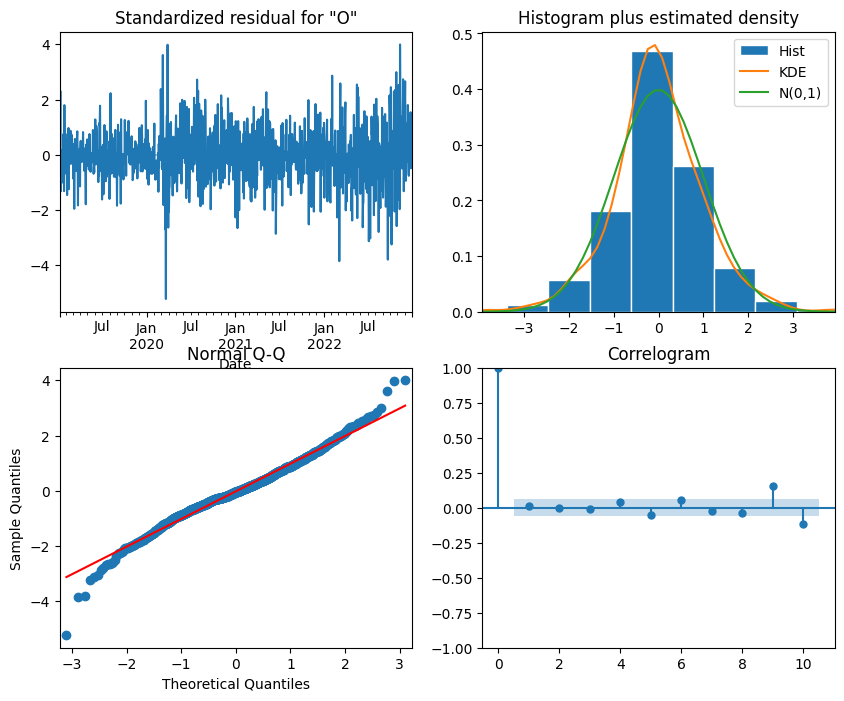

In [25]:
cur_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


### **1. Standardized Residulal** : This residual doesnt show any pattern and are randomly distributed around zero.
### **2. Histogram Plust esitmeted density** : Residuals are normally distriuted
### **3. Normal Q-Q Plot** : Most of the are along red line
### **4. Correlogram** : Its and ACF plot of residuals at diffrent lag and its mostly surrounded near 0
### To confirm plotted residual ACF and no lags were observed

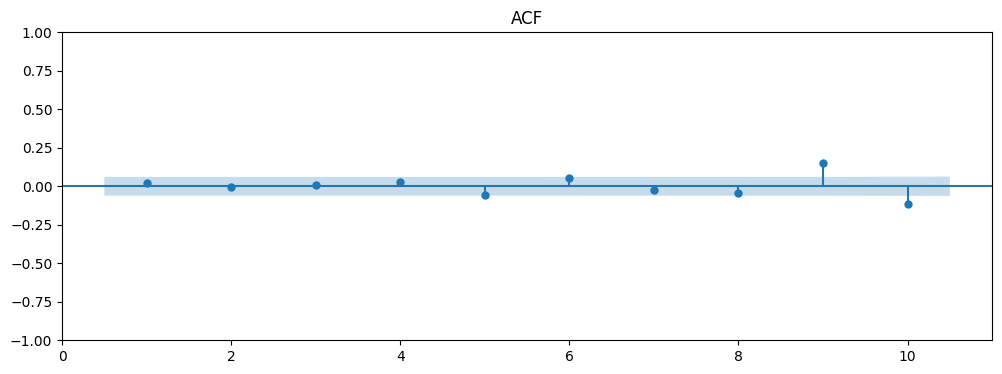

In [26]:
reid=cur_model_fit.resid
plot_acf_values(reid,10)


# Predicting the result for In sample Prediction

# Testing Started

In [27]:
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_data_currency), alpha=0.05,exog=test_data_currency[exogdata])


# Create a new dataframe to hold the forecast
test_data_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_data_currency['Cur predictions'] =  testing_data_forecast.predicted_mean



test_data_currency[['Original_USD_EUR_Price_Predicted']] = scaler.inverse_transform(test_data_currency[['Cur predictions']])
test_data_currency

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,Original_USD_EUR_Price_MA_5_Scaled_shift3,Original_USD_EUR_Price_MA_5_Scaled_shift4,lower Cur predictions,Higher Cur predictions,Cur predictions,Original_USD_EUR_Price_Predicted
Date,,,,,,,,,,,
2023-01-02,1.070973,1.065543,-0.940785,-0.955331,-0.975252,-0.981903,-0.985432,-0.995448,-0.921845,-0.958647,1.064513
2023-01-03,1.067771,1.066292,-0.927778,-0.940785,-0.955331,-0.975252,-0.981903,-0.982177,-0.892737,-0.937457,1.065734
2023-01-04,1.054685,1.064486,-0.959109,-0.927778,-0.940785,-0.955331,-0.975252,-1.001284,-0.859114,-0.930199,1.066153
2023-01-05,1.060637,1.064028,-0.967048,-0.959109,-0.927778,-0.940785,-0.955331,-1.052196,-0.877308,-0.964752,1.064161
2023-01-06,1.052222,1.061258,-1.015108,-0.967048,-0.959109,-0.927778,-0.940785,-1.057764,-0.846762,-0.952263,1.064881
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,1.089064,1.089055,-0.532936,-0.540779,-0.520223,-0.495149,-0.496058,-1.248009,-0.118114,-0.683061,1.080401
2023-07-10,1.096972,1.090300,-0.511352,-0.532936,-0.540779,-0.520223,-0.495149,-1.241051,-0.106962,-0.674006,1.080923
2023-07-11,1.100594,1.092157,-0.479142,-0.511352,-0.532936,-0.540779,-0.520223,-1.230206,-0.091940,-0.661073,1.081668


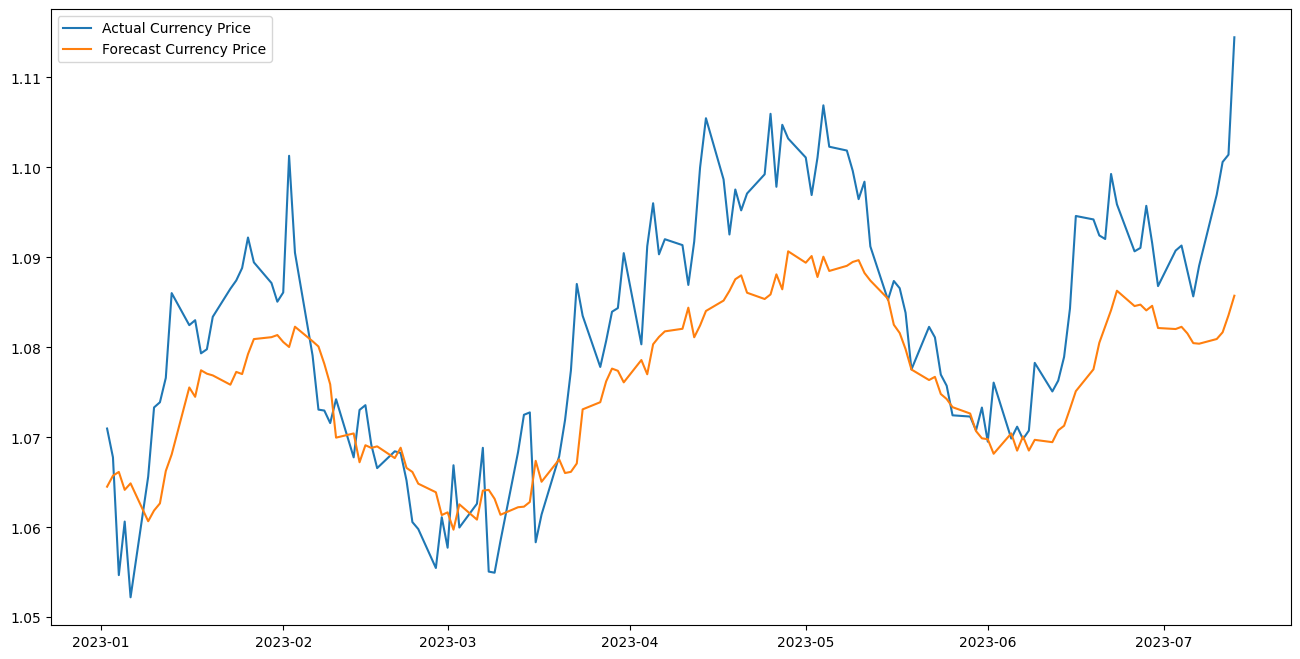

In [28]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_data_currency['Original_USD_EUR_Price_Predicted'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [29]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}



In [30]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'], test_data_currency['Original_USD_EUR_Price_Predicted'])
metrics

{'Mean Absolute Error': 0.007950709744214923,
 'Mean Squared Error': 9.338588858705932e-05,
 'Root Mean Squared Error': 0.009663637440791087,
 'Mean Absolute Percentage Error': 0.7307856895955849}

In [31]:
df_USD_EUR_5_days

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled
Date,,,
2019-01-01,1.149306,1.149306,0.512162
2019-01-02,1.146171,1.147739,0.484971
2019-01-03,1.131811,1.142429,0.392876
2019-01-04,1.139108,1.141599,0.378472
2019-01-07,1.141044,1.141488,0.376548
...,...,...,...
2023-07-07,1.089064,1.089055,-0.532936
2023-07-10,1.096972,1.090300,-0.511352
2023-07-11,1.100594,1.092157,-0.479142


In [32]:
generate_shift_columns(df_USD_EUR_5_days, 'Original_USD_EUR_Price_MA_5_Scaled', 6, 7)
df_USD_EUR_5_days.head(10)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift6,Original_USD_EUR_Price_MA_5_Scaled_shift7
Date,,,,,
2019-01-01,1.149306,1.149306,0.512162,NaN,NaN
2019-01-02,1.146171,1.147739,0.484971,NaN,NaN
2019-01-03,1.131811,1.142429,0.392876,NaN,NaN
2019-01-04,1.139108,1.141599,0.378472,NaN,NaN
2019-01-07,1.141044,1.141488,0.376548,NaN,NaN
2019-01-08,1.147974,1.141222,0.371925,NaN,NaN
2019-01-09,1.145607,1.141109,0.369966,0.512162,NaN
2019-01-10,1.155495,1.145846,0.452131,0.484971,0.512162
2019-01-11,1.151013,1.148227,0.493431,0.392876,0.484971


In [33]:
df_USD_EUR_5_days.dropna(inplace=True)

In [34]:
train_data_currency = df_USD_EUR_5_days[df_USD_EUR_5_days.index <= train_end_date]
test_data_currency = df_USD_EUR_5_days[df_USD_EUR_5_days.index > train_end_date]
train_data_currency.head(5)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift6,Original_USD_EUR_Price_MA_5_Scaled_shift7
Date,,,,,
2019-01-10,1.155495,1.145846,0.452131,0.484971,0.512162
2019-01-11,1.151013,1.148227,0.493431,0.392876,0.484971
2019-01-14,1.146014,1.149220,0.510670,0.378472,0.392876
2019-01-15,1.147289,1.149083,0.508294,0.376548,0.378472
2019-01-16,1.141683,1.148299,0.494682,0.371925,0.376548


In [35]:

# from pmdarima import auto_arima
# model = auto_arima(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'],exog=train_data_currency[exogdata],
#                          seasonal=False,   # No Seasonality
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=False)
# model.summary()


In [36]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # define the range for p and q
# p_values = range(0, 7)
# q_values = range(0, 7)
# d_values = [0, 1]

# # iterate through all the combinations
# for d in d_values:
#     for p in p_values:
#         for q in q_values:
#             try:
#                 # define the model
#                 cur_model = SARIMAX(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'], order=(p, d, q), exog=train_data_currency[exogdata])
#                 # fit the model
#                 cur_model_fit = cur_model.fit(maxiter=1000)
#                 # print summary
#                 print(f'ARIMA({p},{d},{q}) - AIC:{cur_model_fit.aic}, Log-Likelihood:{cur_model_fit.llf}')
#             except:
#                 continue


In [37]:
exogdata=['Original_USD_EUR_Price_MA_5_Scaled_shift6','Original_USD_EUR_Price_MA_5_Scaled_shift7']


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

cur_model=SARIMAX(train_data_currency['Original_USD_EUR_Price_MA_5_Scaled'],order=(5,1,3),exog=train_data_currency[exogdata])
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5_Scaled   No. Observations:                 1037
Model:                               SARIMAX(5, 1, 3)   Log Likelihood                2645.068
Date:                                Fri, 14 Jul 2023   AIC                          -5268.136
Time:                                        11:06:05   BIC                          -5213.762
Sample:                                    01-10-2019   HQIC                         -5247.505
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Original_USD_EUR_Price_MA_5_Scaled_shift6     0.2400      0.040      6.008      0.000       0.162       0.318
Original_USD_EUR_Price_MA_5_Scaled_shift7     0.1120      0.032      3.518      0.000       0.050       0.174
ar.L1                                         0.8220      0.077     10.679      0.000       0.671       0.973
ar.L2                                        -0.3162      0.109     -2.888      0.004      -0.531      -0.102
ar.L3                                        -0.1962      0.099     -1.986      0.047      -0.390      -0.003
ar.L4                                         0.4746      0.063      7.564      0.000       0.352       0.598
ar.L5                                        -0.4790      0.032    -15.203      0.000      -0.541      -0.417
ma.L1                                         0.0715      0.078      0.920      0.358      -0.081       0.224
ma.L2                                         0.5697      0.048     11.908      0.000       0.476       0.663
ma.L3                                         0.6867      0.078      8.835      0.000       0.534       0.839
sigma2                                        0.0004   1.17e-05     29.932      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               173.74
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

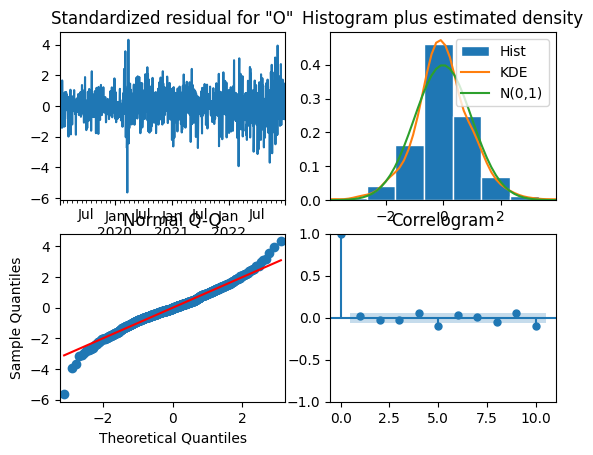

In [39]:
cur_model_fit.plot_diagnostics()
plt.show()

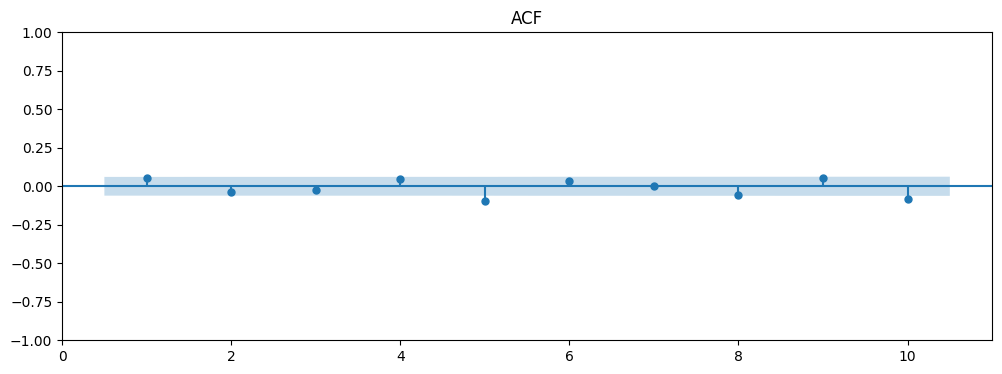

In [40]:
plot_acf_values(cur_model_fit.resid,10)

In [41]:
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_data_currency), alpha=0.05,exog=test_data_currency[exogdata])


# Create a new dataframe to hold the forecast
test_data_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_data_currency['Cur predictions'] =  testing_data_forecast.predicted_mean


test_data_currency[['Original_USD_EUR_Price_Predicted']] = scaler.inverse_transform(test_data_currency[['Cur predictions']])
test_data_currency

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,Original_USD_EUR_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift6,Original_USD_EUR_Price_MA_5_Scaled_shift7,lower Cur predictions,Higher Cur predictions,Cur predictions,Original_USD_EUR_Price_Predicted
Date,,,,,,,,,
2023-01-02,1.070973,1.065543,-0.940785,-1.023040,-1.010124,-0.987470,-0.914023,-0.950747,1.064968
2023-01-03,1.067771,1.066292,-0.927778,-0.994326,-1.023040,-1.020627,-0.863348,-0.941987,1.065473
2023-01-04,1.054685,1.064486,-0.959109,-0.985432,-0.994326,-1.061605,-0.797927,-0.929766,1.066178
2023-01-05,1.060637,1.064028,-0.967048,-0.981903,-0.985432,-1.109789,-0.720380,-0.915085,1.067024
2023-01-06,1.052222,1.061258,-1.015108,-0.975252,-0.981903,-1.173522,-0.651819,-0.912671,1.067163
...,...,...,...,...,...,...,...,...,...
2023-07-07,1.089064,1.089055,-0.532936,-0.464821,-0.438179,-2.183481,0.688157,-0.747662,1.076676
2023-07-10,1.096972,1.090300,-0.511352,-0.496347,-0.464821,-2.199297,0.682868,-0.758215,1.076068
2023-07-11,1.100594,1.092157,-0.479142,-0.496058,-0.496347,-2.208004,0.684648,-0.761678,1.075868


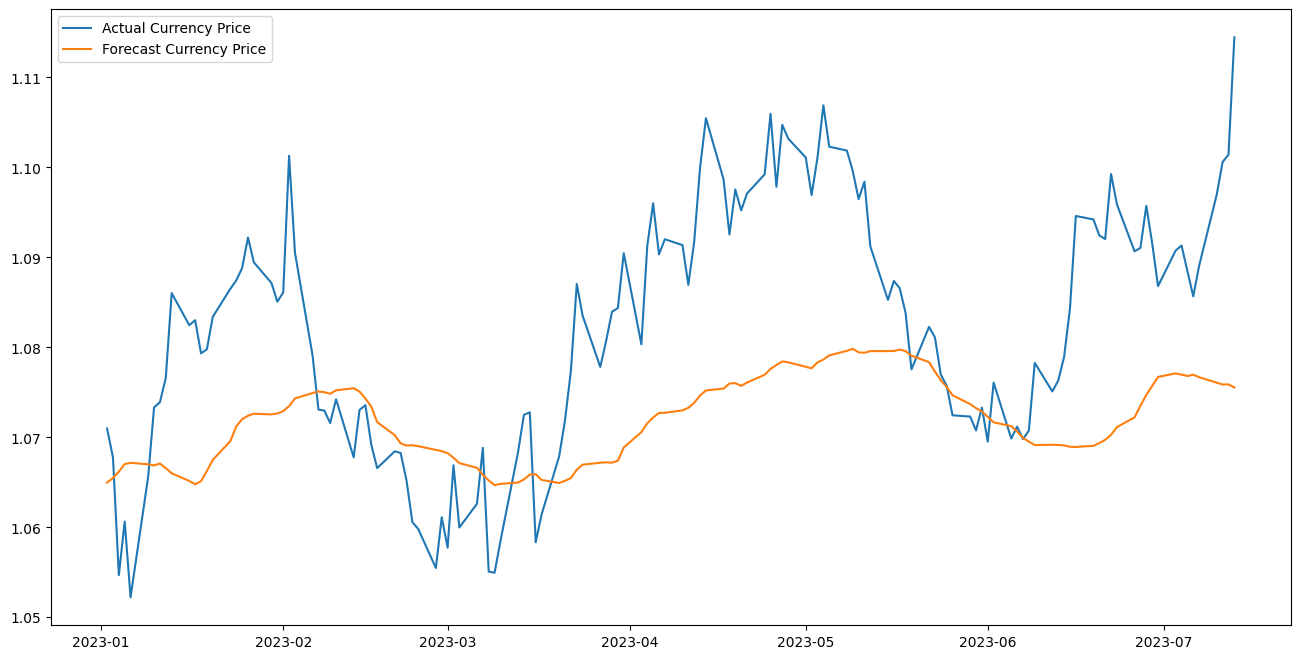

In [42]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_data_currency['Original_USD_EUR_Price_Predicted'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [43]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'], test_data_currency['Original_USD_EUR_Price_Predicted'])
metrics

{'Mean Absolute Error': 0.012663474057930708,
 'Mean Squared Error': 0.00023288429477659876,
 'Root Mean Squared Error': 0.015260547001225047,
 'Mean Absolute Percentage Error': 1.1624947955699607}